In [1]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin
from sklearn.linear_model import LinearRegression

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_supp_LP1 = "../svg/panel_supp_lp1.svg"
PANEL_supp_LP2 = "../svg/panel_supp_lp2.svg"
PANEL_supp_PY1 = "../svg/panel_supp_py1.svg"
PANEL_supp_PY2 = "../svg/panel_supp_py2.svg"

PANEL_supp_LP_EV1 = "../svg/panel_supp_lp_ev1.svg"
PANEL_supp_LP_EV2 = "../svg/panel_supp_lp_ev2.svg"
PANEL_supp_PY_EV1 = "../svg/panel_supp_py_ev1.svg"
PANEL_supp_PY_EV2 = "../svg/panel_supp_py_ev2.svg"

PANEL_supp_LP_syn1 = "../svg/panel_supp_lp_syn1.svg"
PANEL_supp_LP_syn2 = "../svg/panel_supp_lp_syn2.svg"
PANEL_supp_PY_syn1 = "../svg/panel_supp_py_syn1.svg"
PANEL_supp_PY_syn2 = "../svg/panel_supp_py_syn2.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

###  Fit regression net for total energy

In [7]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [8]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = "cpu"
    posterior._sample_with = "rejection"

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1130: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [9]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

# Energy per spike

In [41]:
energies = x["energies"]
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [42]:
num_test = 500

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [43]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["LP"].to_numpy() / 1000

all_e_per_spike_ABPD = torch.as_tensor(all_energies_per_spike_ABPD)
train_energy_ABPD = all_e_per_spike_ABPD[num_test:].unsqueeze(1)
test_energy_ABPD = all_e_per_spike_ABPD[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

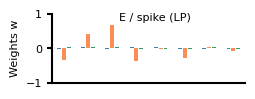

In [54]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        deepcopy(torch.as_tensor(coeff))[0],
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Weights w",
        plot_labels=False,
        legend=False,
        title='E / spike (LP)',
        title_x_offset=0,
        legend_y_offset=0.3,
    )
    plt.savefig(PANEL_supp_LP1, facecolor="None", transparent=True)
    plt.show()

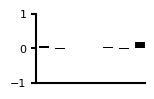

In [45]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-0.3, 0.6], figsize=(1.4, 0.9), ylabel="", color="k", title=None, plot_labels=False
    )
    plt.savefig(PANEL_supp_LP_syn1, facecolor="None", transparent=False)
    plt.show()

## Number of spikes

In [46]:
numSpikesPerBurst = x["num_spikes"]["LP"].to_numpy() / x["num_bursts"]["LP"].to_numpy()

In [47]:
numSpikesPerBurst = torch.as_tensor(numSpikesPerBurst)
train_energy_ABPD = numSpikesPerBurst[num_test:].unsqueeze(1)
test_energy_ABPD = numSpikesPerBurst[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

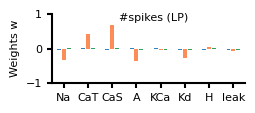

In [48]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Weights w",
        plot_labels=True,
        legend=False,
        legend_y_offset=0.3,
        title='#spikes (LP)',
        title_x_offset=0,
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_supp_LP2, facecolor="None", transparent=True)
    plt.show()

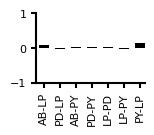

In [59]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(torch.as_tensor(coeff))[:, -7:], ylim=[-0.3, 0.6], figsize=(1.4, 0.9), ylabel="", color="k", title=None, plot_labels=True
    )
    plt.savefig(PANEL_supp_LP_syn2, facecolor="None", transparent=False)
    plt.show()

## Assemble figure

In [50]:
time_vec = np.arange(0, 11000, 0.025)

In [51]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [60]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "10.4cm",

    Panel(
          SVG(PANEL_supp_PY1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0.0*factor_svg, -7+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_PY_syn1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(52.0*factor_svg, 0.3*factor_svg),

    Panel(
          SVG(PANEL_supp_PY2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0.0*factor_svg, 83+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_PY_syn2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(52.0*factor_svg, 90+0.3*factor_svg),

    Panel(
          SVG(PANEL_supp_LP1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0.0*factor_svg, 173+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_LP_syn1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(52.0*factor_svg, 180+0.3*factor_svg),

    Panel(
          SVG(PANEL_supp_LP2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0.0*factor_svg, 263+1.6*factor_svg),

    Panel(
          SVG(PANEL_supp_LP_syn2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(52.0*factor_svg, 270+0.3*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp5.svg")
svg('../fig/fig3_supp5.svg')